- Track Information
<https://github.com/aws-deepracer-community/deepracer-race-data/tree/main/raw_data/tracks>

In [2]:
npy_name = "reInvent2019_track_ccw.npy"

LOOK_AHEAD_POINTS = 5
MIN_SPEED = 1.3
MAX_SPEED = 4

# Number of times to iterate each new race line point
# keep this at 3-8 for best balance of performance and desired result
XI_ITERATIONS=8 # default 4

# Number of times to scan the entire race track to iterate
# 500 will get a good start, 1500 will be closer to optimal result
LINE_ITERATIONS=500 # default 1000

In [ ]:
#git clone https://github.com/aws-deepracer-community/deepracer-race-data.git

Cloning into 'deepracer-race-data'...
remote: Enumerating objects: 520988, done.
remote: Counting objects: 100% (15743/15743), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 520988 (delta 15738), reused 15733 (delta 15731), pack-reused 505245 (from 3)
Receiving objects: 100% (520988/520988), 288.47 MiB | 15.17 MiB/s, done.
Resolving deltas: 100% (384065/384065), done.
Updating files: 100% (43576/43576), done.


In [3]:
import os

npy_folder_path = "deepracer-race-data/raw_data/tracks/npy"
TRACK_NAME = npy_name.split('.')[0]
numpy_file_path = os.path.join(npy_folder_path, npy_name)

---

# [1] Race-Line-Calculation.ipynb

## Racing Line Calculation Worksheet

Inspired by the paper [Reinforcement Learning Using Neural Networks, with Applications to Motor Control
](https://www.remi-coulom.fr/Publications/Thesis.pdf), which is referenced by a number of machine learning articles, we calculate a race line around a simple race track.

#### New notebook

This notebook was forked from [this](https://github.com/cdthompson/deepracer-k1999-race-lines/blob/master/Race-Line-Calculation.ipynb) notebook by cdthompson.

This repo only contains the new notebook, not the entire directory. So make sure to download the entire directory from cdthompson's repo.

In [4]:
import glob
import numpy as np
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString
import pandas as pd
import matplotlib.pyplot as plt
import os.path

### Load the track to analyze

In [ ]:
# # Conveniently list available tracks to analyze
# available_track_files = glob.glob("./tracks/**.npy")
# available_track_names = list(map(lambda x: os.path.basename(x).split('.npy')[0], available_track_files))
# available_track_names

Is loop/ring?  True


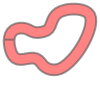

In [5]:
# Load the center, inner, outer waypoints
waypoints = np.load(numpy_file_path)

# Convert to Shapely objects
center_line = waypoints[:,0:2]
inner_border = waypoints[:,2:4]
outer_border = waypoints[:,4:6]
l_center_line = LineString(center_line)
l_inner_border = LineString(inner_border)
l_outer_border = LineString(outer_border)
road_poly = Polygon(np.vstack((outer_border, np.flipud(inner_border))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly

Is loop/ring?  True


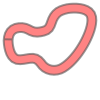

In [6]:
# Own code: Reduce width of track

def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

def x_perc_width(waypoint, perc_width):

    center_x, center_y, inner_x, inner_y, outer_x, outer_y = waypoint

    width = dist_2_points(inner_x, outer_x, inner_y, outer_y)

    delta_x = outer_x-inner_x
    delta_y = outer_y-inner_y

    inner_x_new = inner_x + delta_x/2 * (1-perc_width)
    outer_x_new = outer_x - delta_x/2 * (1-perc_width)
    inner_y_new = inner_y + delta_y/2 * (1-perc_width)
    outer_y_new = outer_y - delta_y/2 * (1-perc_width)

    return [center_x, center_y, inner_x_new, inner_y_new, outer_x_new, outer_y_new]

PERC_WIDTH = 0.8
waypoints_new = [x_perc_width(waypoint, perc_width=PERC_WIDTH) for waypoint in waypoints]
waypoints_new = np.asarray(waypoints_new)

# Convert to Shapely objects
inner_border_new = waypoints_new[:,2:4]
outer_border_new = waypoints_new[:,4:6]
l_inner_border_new = LineString(inner_border_new)
l_outer_border_new = LineString(outer_border_new)
road_poly_new = Polygon(np.vstack((outer_border_new, np.flipud(inner_border_new))))
print("Is loop/ring? ", l_center_line.is_ring)
road_poly_new

## Display the original track waypoints

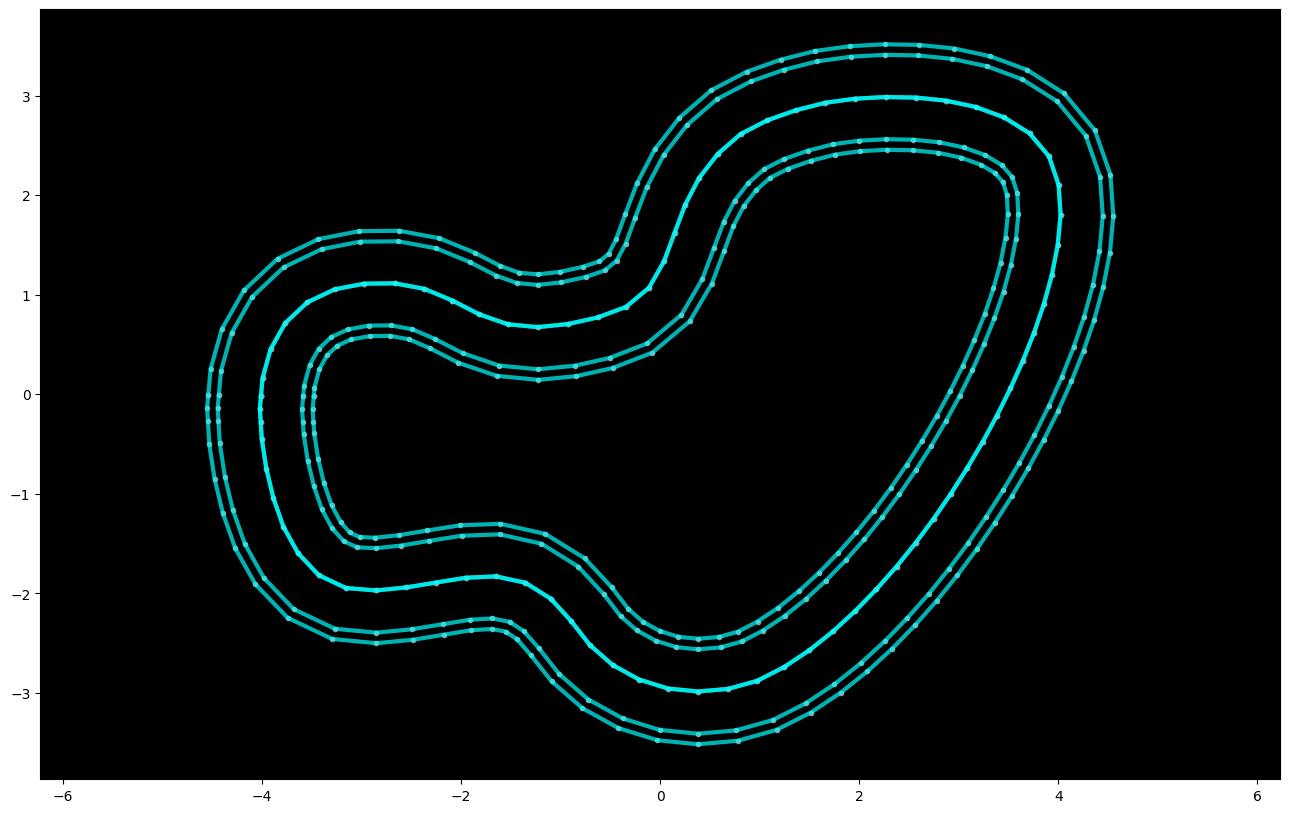

In [7]:
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, '.', color='#999999', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, '.', color='#000000', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='cyan', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

def print_border(ax, waypoints, inner_border_waypoints, outer_border_waypoints):
    line = LineString(waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(inner_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

    line = LineString(outer_border_waypoints)
    plot_coords(ax, line)
    plot_line(ax, line)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, center_line, inner_border, outer_border)

# Also print new border
print_border(ax, center_line, inner_border_new, outer_border_new)


In [8]:
# From https://github.com/e-koch/ewky_scripts/blob/master/curvature.py

# The MIT License (MIT)
#
# Copyright (c) 2014 Eric Koch
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.

def menger_curvature(pt1, pt2, pt3, atol=1e-3):

    vec21 = np.array([pt1[0]-pt2[0], pt1[1]-pt2[1]])
    vec23 = np.array([pt3[0]-pt2[0], pt3[1]-pt2[1]])

    norm21 = np.linalg.norm(vec21)
    norm23 = np.linalg.norm(vec23)

    theta = np.arccos(np.dot(vec21, vec23)/(norm21*norm23))
    if np.isclose(theta-np.pi, 0.0, atol=atol):
        theta = 0.0

    dist13 = np.linalg.norm(vec21-vec23)

    return 2*np.sin(theta) / dist13

In [9]:
import copy
from shapely.geometry import Point, Polygon
from shapely.geometry.polygon import LinearRing, LineString

def improve_race_line(old_line, inner_border, outer_border):
    '''Use gradient descent, inspired by K1999, to find the racing line'''
    # start with the center line
    new_line = copy.deepcopy(old_line)
    ls_inner_border = Polygon(inner_border)
    ls_outer_border = Polygon(outer_border)
    for i in range(0,len(new_line)):
        xi = new_line[i]
        npoints = len(new_line)
        prevprev = (i - 2 + npoints) % npoints
        prev = (i - 1 + npoints) % npoints
        nexxt = (i + 1 + npoints) % npoints
        nexxtnexxt = (i + 2 + npoints) % npoints
        #print("%d: %d %d %d %d %d" % (npoints, prevprev, prev, i, nexxt, nexxtnexxt))
        ci = menger_curvature(new_line[prev], xi, new_line[nexxt])
        c1 = menger_curvature(new_line[prevprev], new_line[prev], xi)
        c2 = menger_curvature(xi, new_line[nexxt], new_line[nexxtnexxt])
        target_ci = (c1 + c2) / 2
        #print("i %d ci %f target_ci %f c1 %f c2 %f" % (i, ci, target_ci, c1, c2))

        # Calculate prospective new track position, start at half-way (curvature zero)
        xi_bound1 = copy.deepcopy(xi)
        xi_bound2 = ((new_line[nexxt][0] + new_line[prev][0]) / 2.0, (new_line[nexxt][1] + new_line[prev][1]) / 2.0)
        p_xi = copy.deepcopy(xi)
        for j in range(0,XI_ITERATIONS):
            p_ci = menger_curvature(new_line[prev], p_xi, new_line[nexxt])
            #print("i: {} iter {} p_ci {} p_xi {} b1 {} b2 {}".format(i,j,p_ci,p_xi,xi_bound1, xi_bound2))
            if np.isclose(p_ci, target_ci):
                break
            if p_ci < target_ci:
                # too flat, shrinking track too much
                xi_bound2 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound1[0] + p_xi[0]) / 2.0, (xi_bound1[1] + p_xi[1]) / 2.0)
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound1 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
            else:
                # too curved, flatten it out
                xi_bound1 = copy.deepcopy(p_xi)
                new_p_xi = ((xi_bound2[0] + p_xi[0]) / 2.0, (xi_bound2[1] + p_xi[1]) / 2.0)

                # If iteration pushes the point beyond the border of the track,
                # just abandon the refinement at this point.  As adjacent
                # points are adjusted within the track the point should gradually
                # make its way to a new position.  A better way would be to use
                # a projection of the point on the border as the new bound.  Later.
                if Point(new_p_xi).within(ls_inner_border) or not Point(new_p_xi).within(ls_outer_border):
                    xi_bound2 = copy.deepcopy(new_p_xi)
                else:
                    p_xi = new_p_xi
        new_xi = p_xi
        # New point which has mid-curvature of prev and next points but may be outside of track
        #print((new_line[i], new_xi))
        new_line[i] = new_xi
    return new_line

### Calculate the race line!

In [10]:
print(len(center_line))
# start along centerline of track
race_line = copy.deepcopy(center_line[:-1])  # Use this for centerline being outer bound
for i in range(LINE_ITERATIONS):
    race_line = improve_race_line(race_line, inner_border_new, outer_border_new)  # Remove "_new" for entire track width
    if i % 20 == 0: print("Iteration %d" % i, end="\r", flush=True)

79


These should be the same:  ((79, 2), (79, 2))
Original centerline length: 23.09
New race line length: 20.25


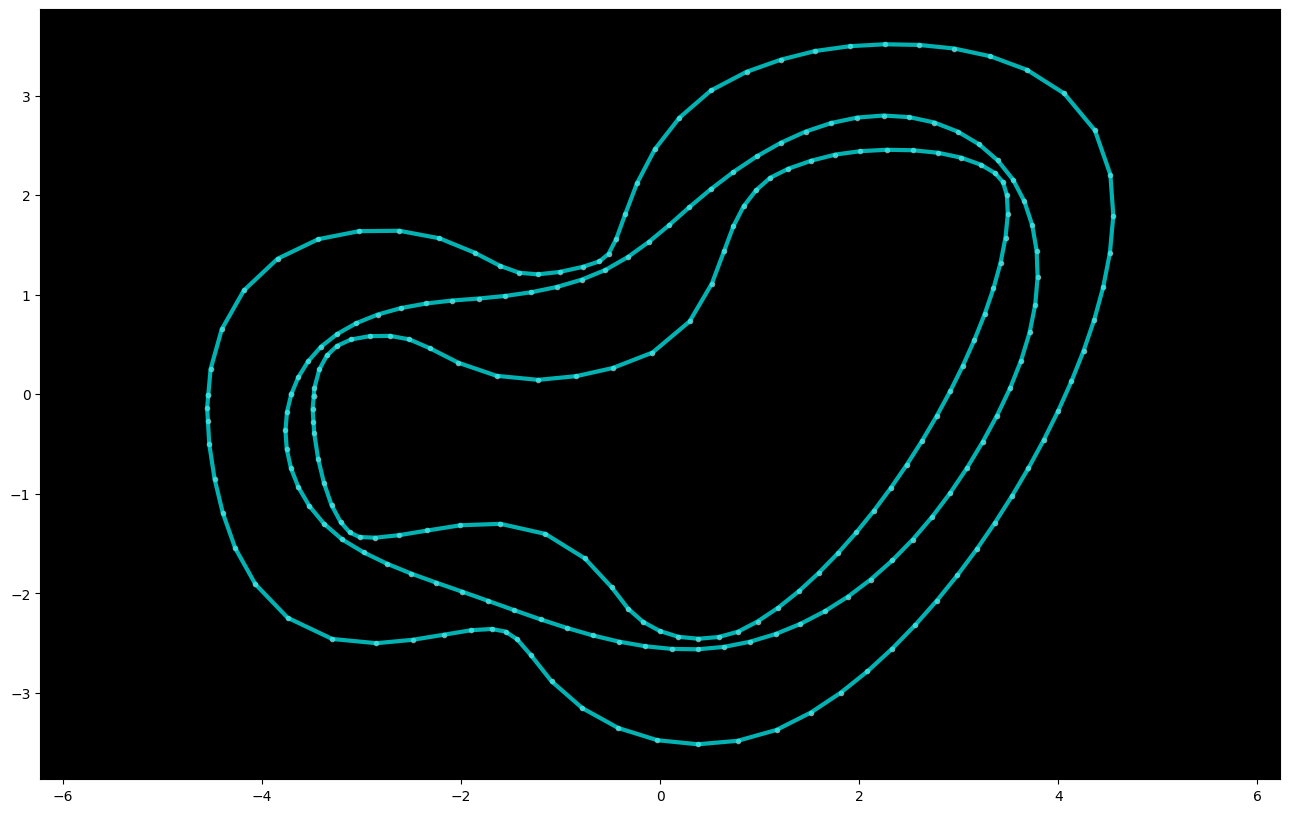

In [11]:
# need to put duplicate point race_line[0] at race_line[-1] to make a closed loops
loop_race_line = np.append(race_line, [race_line[0]], axis=0)

# These should be the same
print("These should be the same: ", (center_line.shape, loop_race_line.shape))
print("Original centerline length: %0.2f" % l_center_line.length)
print("New race line length: %0.2f" % LineString(loop_race_line).length)

fig = plt.figure(1, figsize=(16, 10))
ax = fig.add_subplot(111, facecolor='black')
plt.axis('equal')
print_border(ax, loop_race_line, inner_border, outer_border)

# Also print new border
#print_border(ax, loop_race_line, inner_border_new, outer_border_new)

### Save the raceline as:

1. Binary numpy array for loading from a file
2. Text numpy array for pasting directly into a reward function

In [12]:
from datetime import datetime

now = datetime.now()
prefix = TRACK_NAME + '-raceline'
py_fname = prefix + '.py'
npy_fname = prefix + '.npy'
with open(py_fname, "w") as file:
    print("Writing python code to %s" % py_fname)
    file.write(np.array_repr(loop_race_line))

print("Writing numpy binary to %s" % npy_fname)
np.save(npy_fname, loop_race_line)

Writing python code to reInvent2019_track_ccw-raceline.py
Writing numpy binary to reInvent2019_track_ccw-raceline.npy


## Load and visualize a stored track file

In [ ]:
# from numpy import array

# with open(py_fname, "r") as file:
#     deserialized = eval(file.read())
# deserialized
# fig = plt.figure(1, figsize=(16, 10))
# ax = fig.add_subplot(111, facecolor='black')
# plt.axis('equal')
# print_border(ax, deserialized, inner_border, outer_border)

# [2] RaceLine_Speed_ActionSpace.ipynb


## INSTRUCTIONS
#### Part 1: Computing the optimal speed from the optimal racing line
- Part 1 of this notebook takes the optimal racing line, which can be generated with Race-Line-Calculation.ipynb ([GitHub](https://github.com/cdthompson/deepracer-k1999-race-lines)), and generates the optimal speed for each point on the racing line
- Input: .py file with 2D array containing optimal racing line: 2 columns (x,y)
- Output: .py file with 2D array: 4 columns (x,y,speed,expected time). This array can be inserted into the reward function
- Note: The last point of the racing line is deleted because it is the same point as the first one

#### Part 2: Computing the Action Space
- Part 2 of this notebook takes the optimal racing line and speed, and uses K-Means with Gaussian Noise infused data, to calculate the action space

In [13]:
%matplotlib inline

import numpy as np
import pandas as pd
from scipy import stats
import math
import os

# Ignore deprecation warnings we have no power over
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Path of the optimal racing line (.npy file)

# npy_name = "Spain_track.npy"

# TRACK_NAME = npy_name.split('.')[0]
# numpy_file_path = os.path.join(npy_folder_path, npy_name)

racing_track = np.load(npy_fname)

# Convert np array to list and remove last point because it is the same point as the first one
racing_track = racing_track.tolist()[:-1]

## Helper functions for Part 1 and Part 2

In [15]:
# Uses previous and next coords to calculate the radius of the curve
# so you need to pass a list with form [[x1,y1],[x2,y2],[x3,y3]]
# Input 3 coords [[x1,y1],[x2,y2],[x3,y3]]
def circle_radius(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    a = x1*(y2-y3) - y1*(x2-x3) + x2*y3 - x3*y2
    b = (x1**2+y1**2)*(y3-y2) + (x2**2+y2**2)*(y1-y3) + (x3**2+y3**2)*(y2-y1)
    c = (x1**2+y1**2)*(x2-x3) + (x2**2+y2**2)*(x3-x1) + (x3**2+y3**2)*(x1-x2)
    d = (x1**2+y1**2)*(x3*y2-x2*y3) + (x2**2+y2**2) * \
        (x1*y3-x3*y1) + (x3**2+y3**2)*(x2*y1-x1*y2)

    # In case a is zero (so radius is infinity)
    try:
        r = abs((b**2+c**2-4*a*d) / abs(4*a**2)) ** 0.5
    except:
        r = 999

    return r


# Returns indexes of next index and index+lookfront
# We need this to calculate the radius for next track section.
def circle_indexes(mylist, index_car, add_index_1=0, add_index_2=0):

    list_len = len(mylist)

    # if index >= list_len:
    #     raise ValueError("Index out of range in circle_indexes()")

    # Use modulo to consider that track is cyclical
    index_1 = (index_car + add_index_1) % list_len
    index_2 = (index_car + add_index_2) % list_len

    return [index_car, index_1, index_2]


def optimal_velocity(track, min_speed, max_speed, look_ahead_points):

    # Calculate the radius for every point of the track
    radius = []
    for i in range(len(track)):
        indexes = circle_indexes(track, i, add_index_1=-1, add_index_2=1)
        coords = [track[indexes[0]],
                  track[indexes[1]], track[indexes[2]]]
        radius.append(circle_radius(coords))

    # Get the max_velocity for the smallest radius
    # That value should multiplied by a constant multiple
    v_min_r = min(radius)**0.5
    constant_multiple = min_speed / v_min_r
    print(f"Constant multiple for optimal speed: {constant_multiple}")

    if look_ahead_points == 0:
        # Get the maximal velocity from radius
        max_velocity = [(constant_multiple * i**0.5) for i in radius]
        # Get velocity from max_velocity (cap at MAX_SPEED)
        velocity = [min(v, max_speed) for v in max_velocity]
        return velocity

    else:
        # Looks at the next n radii of points and takes the minimum
        # goal: reduce lookahead until car crashes bc no time to break
        LOOK_AHEAD_POINTS = look_ahead_points
        radius_lookahead = []
        for i in range(len(radius)):
            next_n_radius = []
            for j in range(LOOK_AHEAD_POINTS+1):
                index = circle_indexes(
                    mylist=radius, index_car=i, add_index_1=j)[1]
                next_n_radius.append(radius[index])
            radius_lookahead.append(min(next_n_radius))
        max_velocity_lookahead = [(constant_multiple * i**0.5)
                                  for i in radius_lookahead]
        velocity_lookahead = [min(v, max_speed)
                              for v in max_velocity_lookahead]
        return velocity_lookahead


# For each point in racing track, check if left curve (returns boolean)
def is_left_curve(coords):

    # Flatten the list and assign to variables (makes code easier to read later)
    x1, y1, x2, y2, x3, y3 = [i for sub in coords for i in sub]

    return ((x2-x1)*(y3-y1) - (y2-y1)*(x3-x1)) > 0


# Calculate the distance between 2 points
def dist_2_points(x1, x2, y1, y2):
        return abs(abs(x1-x2)**2 + abs(y1-y2)**2)**0.5

## Part 1: Calculate optimal speed

- Change ```LOOK_AHEAD_POINTS``` to influence how many points the algorithm looks ahead (the higher, the sooner the car will start to break)
- Change ```MIN_SPEED``` and ```MAX_SPEED``` to fit the track and model !

In [16]:
# LOOK_AHEAD_POINTS = 5
# MIN_SPEED = 1.3
# MAX_SPEED = 4

# Calculate optimal speed
velocity = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=LOOK_AHEAD_POINTS)

Constant multiple for optimal speed: 1.2377267324346641


#### Visualization

Constant multiple for optimal speed: 1.2377267324346641


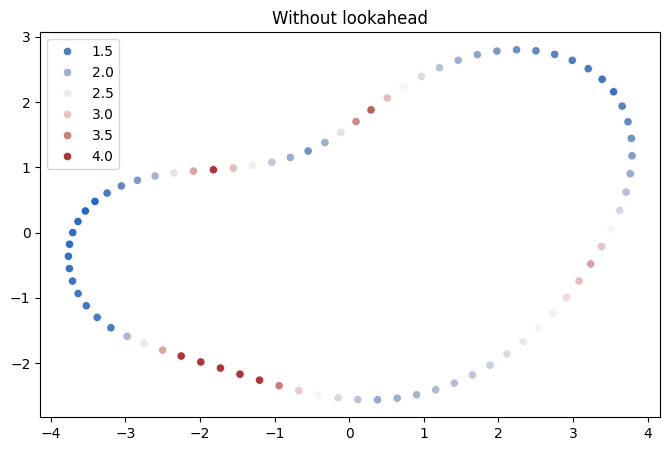

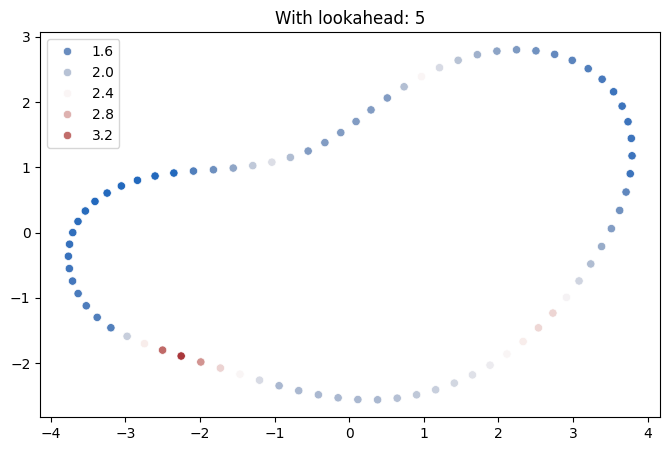

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns

x = [i[0] for i in racing_track]
y = [i[1] for i in racing_track]

# Without lookahead
velocity_no_lookahead = optimal_velocity(track=racing_track,
    min_speed=MIN_SPEED, max_speed=MAX_SPEED, look_ahead_points=0)

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity_no_lookahead,
                     palette="vlag").set_title("Without lookahead")

fig, ax = plt.subplots(figsize=(8, 5))
ax = sns.scatterplot(x=x, y=y, hue=velocity, palette="vlag").set_title(
    f"With lookahead: {LOOK_AHEAD_POINTS}")

#### Calculate distance and optimal time between each racing point

In [18]:
distance_to_prev = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=0)[0:2]
    coords = [racing_track[indexes[0]],racing_track[indexes[1]]]
    dist_to_prev = dist_2_points(x1=coords[0][0], x2=coords[1][0], y1=coords[0][1], y2=coords[1][1])
    distance_to_prev.append(dist_to_prev)

time_to_prev = [(distance_to_prev[i]/velocity[i]) for i in range(len(racing_track))]

total_time = sum(time_to_prev)
print(f"Total time for track, if racing line and speeds are followed perfectly: {total_time} s")

Total time for track, if racing line and speeds are followed perfectly: 11.44197202908278 s


### Append everything together and save to .txt file

In [19]:
# Now we have list with columns (x,y,speed,distance,time)
racing_track_everything = []
for i in range(len(racing_track)):
    racing_track_everything.append([racing_track[i][0],
                                    racing_track[i][1],
                                    velocity[i],
                                    time_to_prev[i]])
# Round to 5 decimals
racing_track_everything = np.around(racing_track_everything, 5).tolist()

In [20]:
# Write to txt file
with open(f'optimals_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write("[")
    for line in racing_track_everything:
        f.write("%s" % line)
        if line != racing_track_everything[-1]:
            f.write(",\n")
    f.write("]")

## Part 2: Calculate Optimal Action Space

In [21]:
# Calculate the radius for every point of the racing_track
radius = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1) # CHANGE BACK? 1;2
    coords = [racing_track[indexes[0]],
              racing_track[indexes[1]], racing_track[indexes[2]]]
    radius.append(circle_radius(coords))

# Calculate curve direction
left_curve = []
for i in range(len(racing_track)):
    indexes = circle_indexes(racing_track, i, add_index_1=-1, add_index_2=1)
    coords = [racing_track[indexes[1]],
              racing_track[indexes[0]], racing_track[indexes[2]]]
    left_curve.append(is_left_curve(coords))

# Calculate radius with + and - for direction (+ is left, - is right)
radius_direction = []
for i in range(len(racing_track)):
    radius_with_direction = radius[i]
    if left_curve[i] == False:
        radius_with_direction *= -1
    radius_direction.append(radius_with_direction)

# Calculate steering with + and -
dist_wheels_front_back = 0.165 # meters
steering = []
for i in range(len(racing_track)):
    steer = math.degrees(math.asin(dist_wheels_front_back/radius_direction[i]))
    steering.append(steer)

# Merge relevant lists into dataframe
all_actions = pd.DataFrame({"velocity":velocity,
                            "steering":steering})

In [22]:
min(radius)

1.1031565875329132

Text(0.5, 1.0, 'With lookahead: 5')

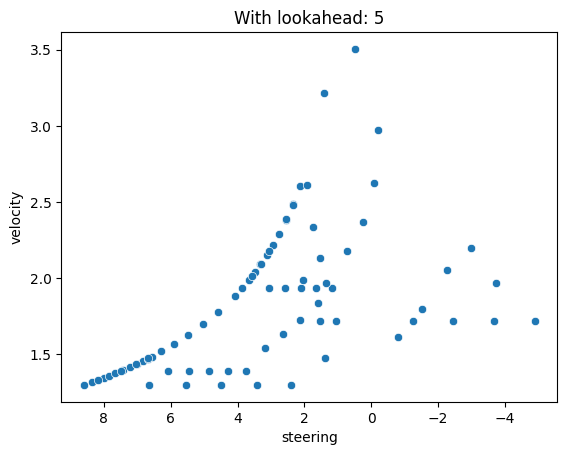

In [23]:
# Visualize action space
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity")
ax.invert_xaxis()
ax.set_title(f"With lookahead: {LOOK_AHEAD_POINTS}")

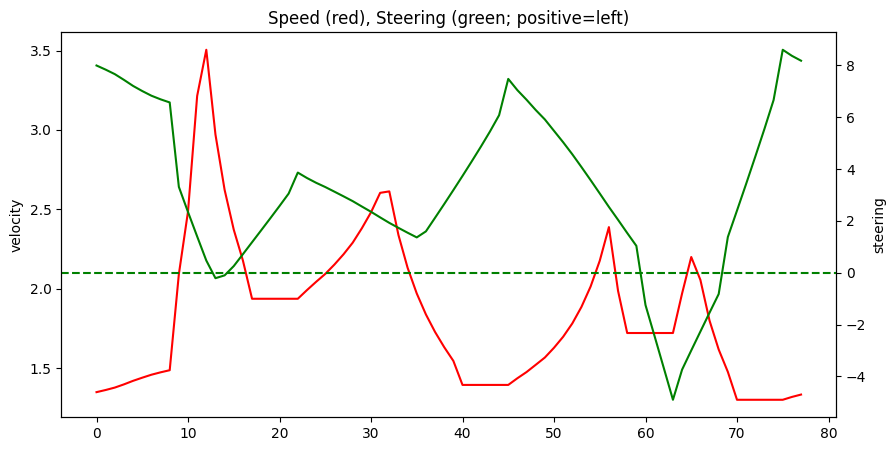

In [24]:
# Visualize all actions
plt.figure(figsize=(10, 5))
sns.lineplot(data=all_actions["velocity"], color="r")
ax2 = plt.twinx()
sns.lineplot(data=all_actions["steering"], color="g", ax=ax2)
plt.axhline(0, ls='--', color="g")
a = plt.title("Speed (red), Steering (green; positive=left)")

#### Calculate Action Space with K-Means and Resampling each point with normal distribution

<Axes: ylabel='Density'>

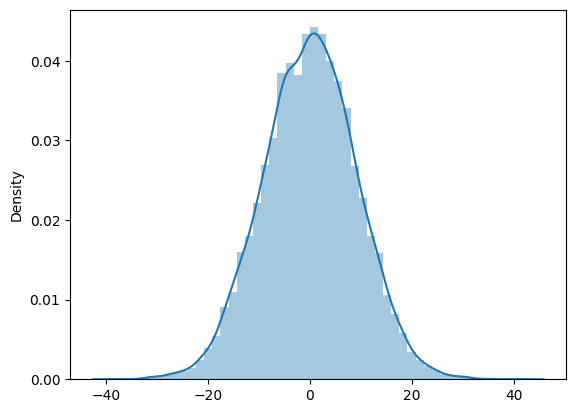

In [25]:
# Steering: Find standard deviation so that probability of >10 degrees steering is 5%
steering_sd = -15 / stats.norm.ppf(0.05)
steering_sd
sns.distplot(np.random.normal(0,steering_sd,10000))

<Axes: ylabel='Density'>

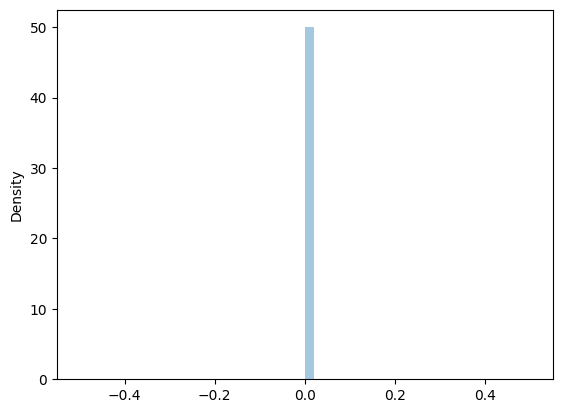

In [26]:
# Velocity: Find standard deviation so that probability of >0.25m/s deviation is 0%
# Note: Here, probability is set to 0%, so no noise regarding velocity
velocity_sd = -0.25 / stats.norm.ppf(0.00)
velocity_sd
sns.distplot(np.random.normal(0,velocity_sd,10000))

In [27]:
all_actions_norm = all_actions.copy()

all_actions_norm_len = len(all_actions_norm)
resample_size = 1000

# Add gaussian noise to action space
for i in range(all_actions_norm_len):
    v_true = all_actions_norm.iloc[i]["velocity"]
    s_true = all_actions_norm.iloc[i]["steering"]
    v_norm = np.random.normal(loc=v_true, scale=velocity_sd, size=resample_size)
    s_norm = np.random.normal(loc=s_true, scale=steering_sd, size=resample_size)
    vs_norm = pd.DataFrame(np.column_stack([v_norm,s_norm]), columns=["velocity","steering"])
    all_actions_norm = pd.concat([all_actions_norm,vs_norm], axis=0, ignore_index=True)

# Take out actions with max speed, so that they are not affected by gaussian noise
# We do this because there are disproportionally many points with max speed, so
# K-Means will focus too much on these
all_actions_norm = all_actions_norm[all_actions_norm["velocity"] < MAX_SPEED]

# Add initial actions to action space (to make clustering more focused on initial actions)
add_n_initial_actions = int(resample_size / 8)
add_initial_actions = pd.DataFrame()
for i in range(add_n_initial_actions):
    add_initial_actions = pd.concat([add_initial_actions,all_actions], axis=0, ignore_index=True)
all_actions_norm = pd.concat([all_actions_norm,add_initial_actions], axis=0, ignore_index=True)


# Display actions shape
all_actions_norm.shape

(87828, 2)

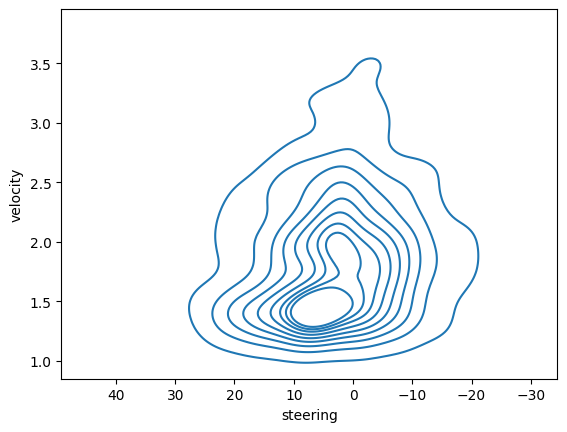

In [28]:
all_actions_norm_less = all_actions_norm.sample(frac=0.01).reset_index(drop=True) # sample bc less compute time
ax = sns.kdeplot(data=all_actions_norm_less, x="steering", y = "velocity")
ax.invert_xaxis()

In [29]:
X = all_actions_norm

# Calculate action space with KMeans

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import MiniBatchKMeans

# Rescale data with minmax
minmax_scaler = MinMaxScaler()
X_minmax = pd.DataFrame(minmax_scaler.fit_transform(X),
                                           columns=["velocity","steering"])

# KMeans
# remove 2 actions from KMeans so that low speed & high steering actions can be manually included
n_clusters = 21-2
model = MiniBatchKMeans(n_clusters=n_clusters).fit(X_minmax)

# Centroids (interpretable)
from sklearn.preprocessing import MinMaxScaler
minmax_scaler = MinMaxScaler()
X_minmax_fit = minmax_scaler.fit(X)
X_centroids = pd.DataFrame(X_minmax_fit.inverse_transform(model.cluster_centers_),
                                   columns=["velocity","steering"])

# Add 2 manual actions
# Reason: When car starts new episode, it does not start on or direction of racing line, so
# it cannot steer enough to get on racing line
manual_actions = pd.DataFrame({"velocity":[MIN_SPEED,MIN_SPEED],"steering":[30,-30]})
X_centroids = pd.concat([X_centroids,manual_actions], ignore_index=True)

action_space_e = X_centroids.copy()

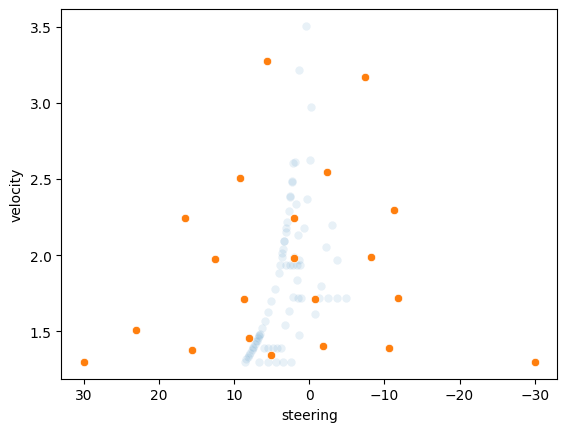

In [30]:
ax = sns.scatterplot(data=all_actions, x="steering", y="velocity", alpha=.1)
ax = sns.scatterplot(data=action_space_e, x="steering", y="velocity")
ax.invert_xaxis()

*Note: Action space can be different every time it is computed because of randome resampling with gaussian noise and also because of the random seed with K-Means. Therefore, try out multiple iterations until you are happy with the result*

#### Output as JSON format

In [31]:
# Output JSON format
action_space_for_json = action_space_e[["steering","velocity"]].copy()

action_space_for_json = action_space_for_json.round(4)
action_space_for_json.columns = ["steering_angle","speed"]
action_space_for_json["index"] = action_space_for_json.index
json_text = action_space_for_json.to_json(orient="records", lines=False)

action_space_for_json

,steering_angle,speed,index
0,-0.8183,1.7128,0
1,5.6548,3.2721,1
2,-8.2567,1.9881,2
3,15.6649,1.3760,3
4,2.0586,1.9828,4
5,5.1463,1.3478,5
6,-2.3300,2.5442,6
7,16.5736,2.2459,7
8,-10.5483,1.3933,8
9,12.4880,1.9784,9


In [32]:
with open(f'AS21_newest_{TRACK_NAME}.txt', 'w') as f:
    f.write(json_text)

# [3] Print Results

- optimal [x, y, speed, steering(radian)]

In [33]:
with open(f'optimals_newest_{TRACK_NAME}.txt', 'r') as f:
    file_contents = f.read()

print(file_contents)


[[-3.70671, -0.00069, 1.34807, 0.13673],
[-3.74957, -0.17901, 1.36162, 0.13469],
[-3.76502, -0.36347, 1.37685, 0.13444],
[-3.75216, -0.55237, 1.3971, 0.13552],
[-3.70951, -0.74374, 1.41944, 0.13813],
[-3.63487, -0.935, 1.43914, 0.14265],
[-3.52554, -1.12231, 1.45783, 0.14877],
[-3.37913, -1.29984, 1.47291, 0.15623],
[-3.19534, -1.45904, 1.48626, 0.1636],
[-2.97798, -1.58974, 2.09096, 0.1213],
[-2.74543, -1.70255, 2.48565, 0.10398],
[-2.50243, -1.8016, 3.21395, 0.08165],
[-2.25325, -1.89197, 3.50497, 0.07562],
[-1.98987, -1.98346, 2.97102, 0.09384],
[-1.72714, -2.07653, 2.62301, 0.10627],
[-1.46471, -2.17036, 2.37176, 0.11751],
[-1.20251, -2.26186, 2.17746, 0.12753],
[-0.94016, -2.34729, 1.93638, 0.14249],
[-0.67721, -2.42304, 1.93638, 0.14131],
[-0.41349, -2.48569, 1.93638, 0.13998],
[-0.14904, -2.53195, 1.93638, 0.13864],
[0.1158, -2.55861, 1.93638, 0.13746],
[0.38035, -2.56246, 1.93638, 0.13663],
[0.64322, -2.53782, 1.99091, 0.13261],
[0.90303, -2.48631, 2.04301, 0.12965],
[1.15858, 

- optimal action space (discrete)

In [34]:
import json

with open(f'AS21_newest_{TRACK_NAME}.txt', 'r') as f:
    file_contents = f.read()

# JSON 형식의 문자열을 파이썬 객체로 변환
data = json.loads(file_contents)

# 개행으로 구분하여 객체 출력
for i, obj in enumerate(data):
    if i < len(data) - 1 :
        print(json.dumps(obj)+',')
    else :
        print(json.dumps(obj))


{"steering_angle": -0.8183, "speed": 1.7128, "index": 0},
{"steering_angle": 5.6548, "speed": 3.2721, "index": 1},
{"steering_angle": -8.2567, "speed": 1.9881, "index": 2},
{"steering_angle": 15.6649, "speed": 1.376, "index": 3},
{"steering_angle": 2.0586, "speed": 1.9828, "index": 4},
{"steering_angle": 5.1463, "speed": 1.3478, "index": 5},
{"steering_angle": -2.33, "speed": 2.5442, "index": 6},
{"steering_angle": 16.5736, "speed": 2.2459, "index": 7},
{"steering_angle": -10.5483, "speed": 1.3933, "index": 8},
{"steering_angle": 12.488, "speed": 1.9784, "index": 9},
{"steering_angle": -11.8191, "speed": 1.7186, "index": 10},
{"steering_angle": -7.4043, "speed": 3.1726, "index": 11},
{"steering_angle": 7.9763, "speed": 1.4583, "index": 12},
{"steering_angle": 9.238, "speed": 2.5066, "index": 13},
{"steering_angle": -11.322, "speed": 2.2946, "index": 14},
{"steering_angle": 23.0045, "speed": 1.5085, "index": 15},
{"steering_angle": 8.6776, "speed": 1.7109, "index": 16},
{"steering_angle

In [35]:
waypoints2_str = "waypoints2 = ["
for x, y in [i[:2] for i in racing_track_everything] :
    waypoints2_str += f"\n  [{x}, {y}],"

x, y = racing_track_everything[0][:2]
waypoints2_str += f"\n  [{x}, {y}]"
waypoints2_str += f"\n]"

print(waypoints2_str)

waypoints2 = [
  [-3.70671, -0.00069],
  [-3.74957, -0.17901],
  [-3.76502, -0.36347],
  [-3.75216, -0.55237],
  [-3.70951, -0.74374],
  [-3.63487, -0.935],
  [-3.52554, -1.12231],
  [-3.37913, -1.29984],
  [-3.19534, -1.45904],
  [-2.97798, -1.58974],
  [-2.74543, -1.70255],
  [-2.50243, -1.8016],
  [-2.25325, -1.89197],
  [-1.98987, -1.98346],
  [-1.72714, -2.07653],
  [-1.46471, -2.17036],
  [-1.20251, -2.26186],
  [-0.94016, -2.34729],
  [-0.67721, -2.42304],
  [-0.41349, -2.48569],
  [-0.14904, -2.53195],
  [0.1158, -2.55861],
  [0.38035, -2.56246],
  [0.64322, -2.53782],
  [0.90303, -2.48631],
  [1.15858, -2.40911],
  [1.40868, -2.30709],
  [1.65216, -2.18114],
  [1.88784, -2.0322],
  [2.11454, -1.86134],
  [2.33119, -1.67006],
  [2.53678, -1.46013],
  [2.7306, -1.23375],
  [2.91216, -0.99345],
  [3.08125, -0.74181],
  [3.23809, -0.48136],
  [3.38341, -0.21415],
  [3.51457, 0.05962],
  [3.62575, 0.33881],
  [3.71147, 0.62031],
  [3.76762, 0.9005],
  [3.79156, 1.17572],
  [3.78181